In [1]:
import wandb
from sklearn.model_selection import train_test_split
from tsai.all import *

In [2]:
BS = 64

In [3]:
api = wandb.Api()
artifact = api.artifact('timeseriesbois/PhysioNet_Challenge/preprocessed_dataset:latest')
dataset_path = Path(artifact.download())

wandb: Downloading large artifact preprocessed_dataset:latest, 3148.34MB. 4 files... Done. 0:0:0


In [4]:
dataset_path.ls()

(#4) [Path('artifacts/preprocessed_dataset:v2/code_to_condition.pkl'),Path('artifacts/preprocessed_dataset:v2/.ipynb_checkpoints'),Path('artifacts/preprocessed_dataset:v2/downsampled_signals.npy'),Path('artifacts/preprocessed_dataset:v2/labels.csv')]

In [5]:
data = np.load(dataset_path/"downsampled_signals.npy")
df = pd.read_csv(dataset_path/"labels.csv", index_col=0)

X, y = data, df.values
assert len(X) == len(y), f"Should {len(X)=} == {len(y)=}"

In [6]:
X.shape, y.shape

((6877, 12, 5000), (6877, 9))

<AxesSubplot:title={'center':'Correlation of features & targets'}>

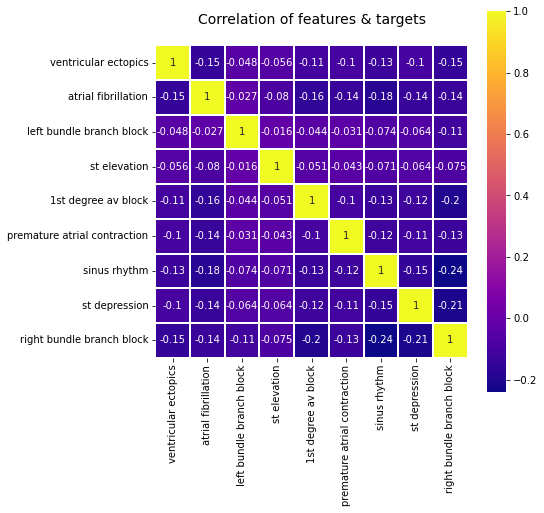

In [7]:
import seaborn as sns
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

## DataLoaders

In [8]:
tfms  = [None, TSClassification()] # TSClassification == Categorize
batch_tfms = TSStandardize()

In [9]:
split = train_test_split(range_of(X), test_size=1000)

In [10]:
dls = get_ts_dls(X, 
                 y, 
                 splits=split,
                 tfms=tfms, 
                 batch_tfms=batch_tfms, 
                 bs=BS)

In [11]:
x,y = dls.one_batch()

In [12]:
x.shape, y.shape

(torch.Size([64, 12, 5000]), torch.Size([64, 9]))

There is a 1 if the disease is present

In [13]:
y[0:5]

TensorCategory([[0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1]], device='cuda:0')

let's try a simple baseline model, the input channels is 12 and the output is the 9 disease

In [14]:
def model_wrap(model):
    "Fix missing cast to plain Tensor"
    return nn.Sequential(model, ToTensorBase())

In [ ]:
model = model_wrap(ResNet(12, 9)).cuda()

In [25]:
from fastai.callback.wandb import WandbCallback

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: capecape (timeseriesbois). Use `wandb login --relogin` to force relogin


In [28]:
with wandb.init(entity="timeseriesbois", project="PhysioNet_Challenge"):
    wandb_cb = WandbCallback(log_preds=False, log_model=False)
    learn = Learner(dls, 
                    model, 
                    loss_func=BCEWithLogitsLossFlat(), 
                    metrics=[accuracy_multi],
                    cbs=wandb_cb).to_fp16()

    learn.fit_one_cycle(10, 1e-3)

## Predictions

In [75]:
inps, preds, tars = learn.get_preds(with_input=True)

In [76]:
from tqdm.notebook import tqdm
import plotly.graph_objects as go

In [77]:
def make_plot(signal):
    "Plots the signal on plotly"
    figure = go.Figure()
    x = list(range(signal.shape[1]))
    figure.add_trace(go.Scatter(x=x, y=signal[0], name=f"Channel 1"))

    for i in range(1, 12):
        figure.add_trace(go.Scatter(x=x, y=signal[i], name=f"Channel {i + 1}", visible="legendonly"))
        
    return figure

In [78]:
signal = inps[0]
signal.shape

torch.Size([12, 5000])

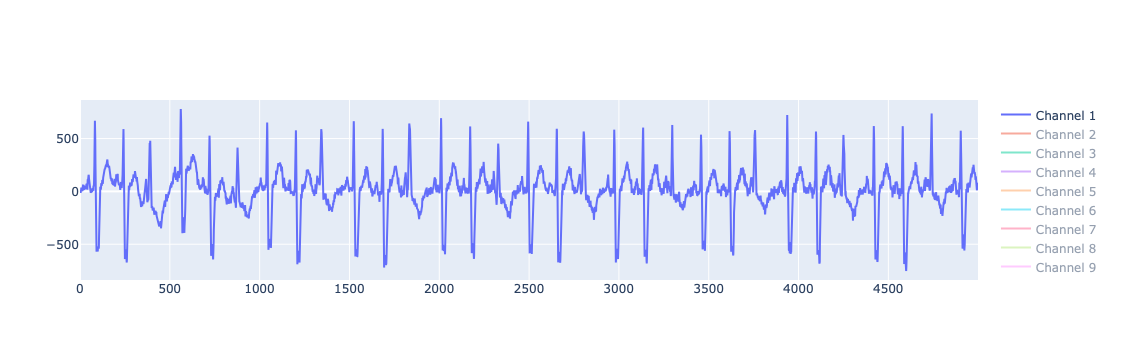

In [95]:
make_plot(signal)

In [96]:
diseases = list(df.columns)

def map_disease(t, th=0.5):
    return [diseases[i] for i in np.where(p>th)[0]]

In [99]:
def log_preds(N=36, seed-42):
    "Log `N` model predictions form the validation dataset"
    columns = ["Input", "Label", "Prediction"]
    table = wandb.Table(columns=columns)

    wandbRandom = random.Random(42)
    idxs = wandbRandom.sample(range_of(preds), k=N)

    for inp,p,t in tqdm(zip(inps[idxs], preds[idxs], tars[idxs]), total=N):
        figure = make_plot(inp)

        row = [
            wandb.Html(figure.to_html()),
            map_disease(p),
            map_disease(p)
        ]
        table.add_data(*row)
        
    with wandb.init(entity="timeseriesbois", project="PhysioNet_Challenge", job_type="log_predictions"):
        wandb.log({"Predictions_Sample":table})

  0%|          | 0/36 [00:00<?, ?it/s]